In [1]:
import sys 
import os 
import pickle
import random
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 
import pandas as pd 
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from typing import Union, Tuple
import scipy.interpolate as itp
import scipy.stats as ss 
from scipy.special import erf, erfc, erfcx
from scipy.stats import norm
import torch
from scipy.interpolate import RegularGridInterpolator

plt.rc('text', usetex=True) # - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
from configuration import get_config
CONFIG = get_config('KiDS-1000')

# Notes
Important columns identified in the catalogue.

## Positions on the sky
- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

## Ellipticities and Weights
- e1
- e2
- weight

## Flux
- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

## Flux Errors
- FLUXERR_GAAP_u (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

## Magnitude
- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

## Magnitude Error
- MAGERR_GAAP_u (mag)
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

## Magnitude Limit
- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

## Flag (all of them 0)
- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

## BPZ
- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [3]:
fits_image = fits.open('./data/catalogue/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

In [4]:
NOBJ = len(data)

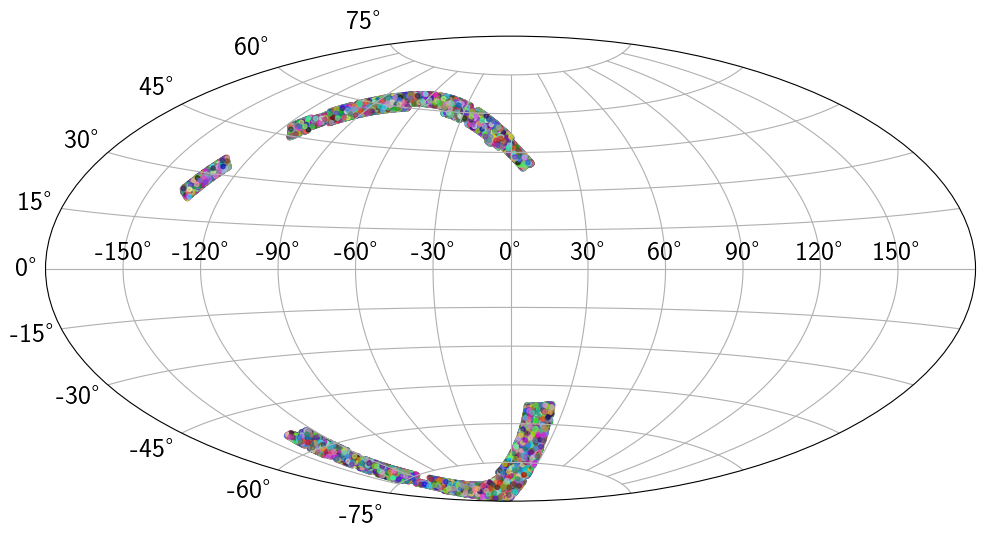

In [6]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 100000
idx = random.sample(range(len(xarr)), nobjects)
eq = SkyCoord(xarr[idx], yarr[idx], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

## Redshifts

In [7]:
rednames = ['Z_B', 'Z_ML']
redshifts = np.asarray([data[rednames[i]] for i in range(len(rednames))]).T
df_redshifts = pd.DataFrame(redshifts, columns = rednames, dtype = np.float16)

In [8]:
df_redshifts.head()

,Z_B,Z_ML
0,0.709961,0.070007
1,0.439941,0.439941
2,1.080078,1.089844
3,0.540039,0.700195
4,1.009766,1.030273


## Names 

In [9]:
names = np.asarray(data['THELI_NAME'], dtype = str)
df_names = pd.DataFrame(names, columns = ['THELI_NAME'])

## Fluxes

In [10]:
fluxes = np.asarray([data[CONFIG.colnames.flux[i]] for i in range(CONFIG.nband)]).T
df_flux = pd.DataFrame(fluxes, columns=CONFIG.colnames.flux, dtype=np.float32)

In [11]:
df_flux.head()

,FLUX_GAAP_u,FLUX_GAAP_g,FLUX_GAAP_r,FLUX_GAAP_i,FLUX_GAAP_Z,FLUX_GAAP_Y,FLUX_GAAP_J,FLUX_GAAP_H,FLUX_GAAP_Ks
0,1.056200e-11,1.392500e-10,1.615300e-10,2.616000e-10,316.019989,557.820007,221.858902,905.090027,924.590027
1,6.060100e-11,8.435300e-10,4.170800e-09,7.162000e-09,11010.000000,14520.000000,18281.925781,24005.000000,27658.000000
2,1.579000e-10,3.678500e-10,6.326800e-10,8.714600e-10,1914.500000,1557.099976,2037.095947,2146.000000,5169.600098
3,2.215500e-10,1.250500e-10,2.747600e-10,2.562200e-10,474.690002,890.419983,382.773987,2217.699951,856.369995
4,1.051100e-10,2.209900e-10,5.564200e-10,1.192700e-09,2096.135986,2520.406494,4021.867676,6219.298828,9032.557617


## Flux Error

In [12]:
flux_err_names = [f'FLUXERR_GAAP_{f}' for f in CONFIG.band]
flux_err = np.asarray([data[flux_err_names[i]] for i in range(CONFIG.nband)]).T
df_flux_err = pd.DataFrame(flux_err, columns=flux_err_names, dtype=np.float32)

In [13]:
df_flux_err.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,6.540000e-11,2.810000e-11,3.120000e-11,7.300000e-11,161.000000,381.000000,424.805298,1030.000000,943.000000
1,7.250000e-11,3.210000e-11,3.710000e-11,8.580000e-11,178.000000,428.000000,481.546692,1200.000000,1100.000000
2,6.910000e-11,3.020000e-11,3.450000e-11,8.000000e-11,170.000000,407.000000,455.338013,1130.000000,1030.000000
3,6.620000e-11,2.860000e-11,3.220000e-11,7.520000e-11,164.000000,390.000000,382.330353,1060.000000,971.000000
4,5.290000e-11,2.640000e-11,2.930000e-11,6.770000e-11,120.152008,280.437103,275.078003,886.384155,702.218994


## Magnitude

In [14]:
mag = np.asarray([data[CONFIG.colnames.mag[i]] for i in range(CONFIG.nband)]).T
df_mag = pd.DataFrame(mag, columns=CONFIG.colnames.mag, dtype=np.float16)

In [15]:
df_mag.head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
0,99.00000,24.546875,24.421875,23.921875,23.718750,23.093750,24.109375,22.59375,22.578125
1,99.00000,22.593750,20.890625,20.328125,19.859375,19.562500,19.328125,19.03125,18.890625
2,24.40625,23.500000,22.937500,22.625000,21.750000,21.984375,21.703125,21.65625,20.703125
3,24.03125,24.671875,23.843750,23.953125,23.265625,22.593750,23.515625,21.62500,22.656250
4,24.81250,24.031250,23.062500,22.265625,21.640625,21.453125,20.968750,20.50000,20.093750


In [16]:
df_mag.max()

MAG_GAAP_u     99.0
MAG_GAAP_g     99.0
MAG_GAAP_r     99.0
MAG_GAAP_i     99.0
MAG_GAAP_Z     99.0
MAG_GAAP_Y     99.0
MAG_GAAP_J     99.0
MAG_GAAP_H     99.0
MAG_GAAP_Ks    99.0
dtype: float16

In [17]:
df_mag.min()

MAG_GAAP_u     17.062500
MAG_GAAP_g     17.859375
MAG_GAAP_r     16.796875
MAG_GAAP_i     16.343750
MAG_GAAP_Z     15.851562
MAG_GAAP_Y     15.664062
MAG_GAAP_J     14.992188
MAG_GAAP_H     14.015625
MAG_GAAP_Ks    15.734375
dtype: float16

## Magnitude Error

In [18]:
magerr_names = [f'MAGERR_GAAP_{f}' for f in CONFIG.band]
magerr = np.asarray([data[magerr_names[i]] for i in range(CONFIG.nband)]).T
df_magerr = pd.DataFrame(magerr, columns = magerr_names, dtype=np.float16)

In [19]:
df_magerr.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,6.722656,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,1.298828,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


## Extinction

In [20]:
ext_names = [f'EXTINCTION_{f}' for f in CONFIG.band]
extinction = np.asarray([data[ext_names[i]] for i in range(CONFIG.nband)]).T
df_ext = pd.DataFrame(extinction, columns = ext_names, dtype=np.float16)

In [21]:
df_ext.head()

,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,EXTINCTION_Z,EXTINCTION_Y,EXTINCTION_J,EXTINCTION_H,EXTINCTION_Ks
0,0.130981,0.102051,0.070618,0.052460,0.039032,0.033661,0.021866,0.013885,0.009300
1,0.131714,0.102600,0.070984,0.052765,0.039246,0.033844,0.021988,0.013962,0.009354
2,0.131958,0.102844,0.071167,0.052856,0.039337,0.033905,0.022034,0.013992,0.009369
3,0.132568,0.103271,0.071411,0.053101,0.039490,0.034058,0.022125,0.014046,0.009407
4,0.162598,0.126709,0.087646,0.065125,0.048431,0.041779,0.027145,0.017227,0.011543


## Magnitude Limit

In [22]:
mag_lim_names = [f'MAG_LIM_{f}' for f in CONFIG.band]
mag_lim = np.asarray([data[mag_lim_names[i]] for i in range(CONFIG.nband)]).T
df_mag_lim = pd.DataFrame(mag_lim, columns = mag_lim_names, dtype=np.float16)

In [23]:
df_mag_lim.head()

,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks
0,25.500000,26.390625,26.281250,25.359375,24.484375,23.546875,23.421875,22.468750,22.562500
1,25.390625,26.250000,26.093750,25.187500,24.375000,23.421875,23.296875,22.296875,22.390625
2,25.437500,26.312500,26.171875,25.265625,24.421875,23.468750,23.359375,22.375000,22.468750
3,25.484375,26.375000,26.250000,25.328125,24.468750,23.515625,23.546875,22.437500,22.531250
4,25.734375,26.453125,26.343750,25.453125,24.796875,23.875000,23.906250,22.625000,22.890625


# Check values in catalog

In [24]:
np.any(df_mag.values < 0)

False

In [25]:
np.any(df_flux.values < 0)

True

In [26]:
np.any(df_flux_err.values < 0)

False

In [27]:
df_mag.min()

MAG_GAAP_u     17.062500
MAG_GAAP_g     17.859375
MAG_GAAP_r     16.796875
MAG_GAAP_i     16.343750
MAG_GAAP_Z     15.851562
MAG_GAAP_Y     15.664062
MAG_GAAP_J     14.992188
MAG_GAAP_H     14.015625
MAG_GAAP_Ks    15.734375
dtype: float16

In [28]:
df_mag.max()

MAG_GAAP_u     99.0
MAG_GAAP_g     99.0
MAG_GAAP_r     99.0
MAG_GAAP_i     99.0
MAG_GAAP_Z     99.0
MAG_GAAP_Y     99.0
MAG_GAAP_J     99.0
MAG_GAAP_H     99.0
MAG_GAAP_Ks    99.0
dtype: float16

# Processing

### Conversion of magnitude error to flux error 

$$
\sigma_{f}^{2} = \frac{4}{25}\,f^{2}\,[{\textrm{ln}(10)}]^{2}\,\sigma_{m}^{2}
$$

In [219]:
def process_flux(flux: pd.DataFrame, fluxerr: pd.DataFrame) -> Union[pd.DataFrame, pd.DataFrame]:
    """
    Process the flux values for the columns ZYJHKs since the zero magnitude is 30. 
    """
    flux = flux.copy(deep=True)
    fluxerr = fluxerr.copy(deep=True)
    
    columns = ['Z', 'Y', 'J', 'H', 'Ks']
    cflux = [f'FLUX_GAAP_{i}' for i in columns]
    cfluxerr = [f'FLUXERR_GAAP_{i}' for i in columns]
        
    flux[cflux] *= 10**(-0.4 * 30)
    fluxerr[cfluxerr] *= 10**(-0.4 * 30)
    return flux, fluxerr


def process_magnitude(mag: pd.DataFrame, magerr: pd.DataFrame, 
                      maglim: pd.DataFrame, flux: pd.DataFrame) -> pd.DataFrame:
    """
    Here, we look at all the objects which 
    1) have magnitudes greater than the magnitude limit 
    2) have magnitude errors which are greater than 1 
    3) have flux values less than 0
    
    and we assign 99 to their magnitude values. 
    """
    mag = mag.copy(deep=True)
    magerr = magerr.copy(deep=True)
    maglim = maglim.copy(deep=True)
    flux = flux.copy(deep=True)
    
    condition_1 = mag.values  > maglim.values
    condition_2 = magerr.values > 1.0
    condition_3 = flux.values < 0.0
    mag.values[condition_1 | condition_2 | condition_3] = 99.0
    return mag

def process_fluxerr(mag: pd.DataFrame, magerr: pd.DataFrame, 
                    maglim: pd.DataFrame, flux: pd.DataFrame, fluxerr: pd.DataFrame):
    """
    We process the flux error in such a way that objects which have a magnitude value of 99 
    will have a magnitude error equal to the magnitude limit. This ensures that the error is sufficiently large
    and we then calculate the error in flux space using an analytic formulae. 
    """
    mag = mag.copy(deep=True)
    magerr = magerr.copy(deep=True)
    maglim = maglim.copy(deep=True)
    flux = flux.copy(deep=True)
    fluxerr = fluxerr.copy(deep=True)
    
    condition = mag.values == 99.0
    magerr.values[condition] = maglim.values[condition]
    
    errmod = 0.4 * np.log(10) * np.abs(flux.values *  magerr.values)
    newerr = pd.DataFrame(np.ma.MaskedArray(errmod,~condition).data, columns = fluxerr.columns)
    return newerr, magerr

In [221]:
flux_corr, fluxerr_corr = process_flux(df_flux, df_flux_err)
mag_corr = process_magnitude(df_mag, df_magerr, df_mag_lim, df_flux)
fluxerr_corr_scaled, magerr_corr = process_fluxerr(mag_corr, df_magerr, df_mag_lim, flux_corr, fluxerr_corr)

# Error Function

In [31]:
def error_function(theory, sigma, nu):
    erf_function = 0.5 * erfc((theory - nu*sigma)/(np.sqrt(2) * sigma))
    normalisation = np.trapz(erf_function, theory)
    return erf_function/normalisation

In [32]:
# list(zip(*np.where(flux_corr.values < 0)))[0]

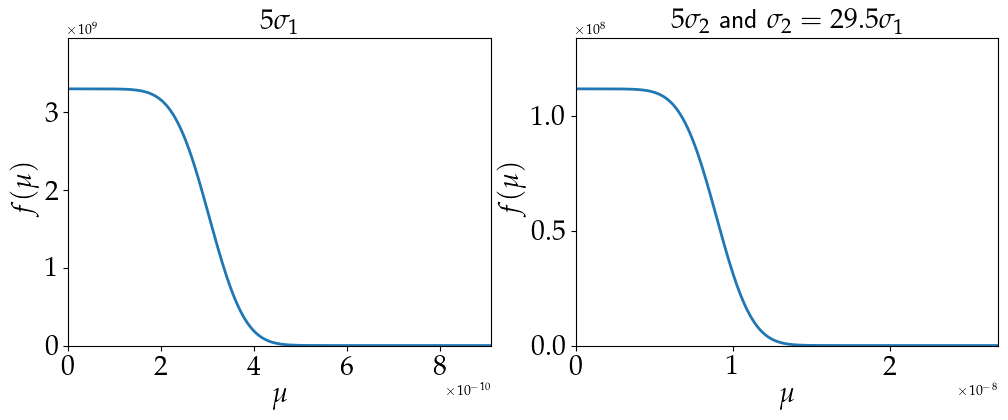

In [33]:
sigma1 = fluxerr_corr.values[17, 0]
sigma2 = fluxerr_corr_scaled.values[17, 0]
xrange1 = np.linspace(0, 15*sigma1, 1000)
xrange2 = np.linspace(0, 15*sigma2, 1000)
erfc1 = error_function(xrange1, sigma1, 5)
erfc2 = error_function(xrange2, sigma2, 5)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(r'$5\sigma_{1}$', fontsize = fontSize)
plt.plot(xrange1, erfc1, lw = 2)
plt.xlim(0, max(xrange1))
plt.ylim(0, 1.2*max(erfc1))
plt.ylabel(r'$f(\mu)$', fontsize = fontSize)
plt.xlabel(r'$\mu$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.title(r'$5\sigma_{2}$ and $\sigma_{2}=29.5\sigma_{1}$', fontsize = fontSize)
plt.plot(xrange2, erfc2, lw = 2)
plt.xlim(0, max(xrange2))
plt.ylim(0, 1.2*max(erfc2))
plt.ylabel(r'$f(\mu)$', fontsize = fontSize)
plt.xlabel(r'$\mu$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

Plot the fluxes

In [34]:
labels = [r'$u$', r'$g$', r'$r$', r'$i$', r'$Z$', r'$Y$', r'$J$', r'$H$', r'$K_{s}$']

Number of objects with good flux is 17260946
Number of objects with good flux is 21057552
Number of objects with good flux is 21261110
Number of objects with good flux is 20883094
Number of objects with good flux is 21135174
Number of objects with good flux is 20489689
Number of objects with good flux is 20977174
Number of objects with good flux is 18994621
Number of objects with good flux is 19203641


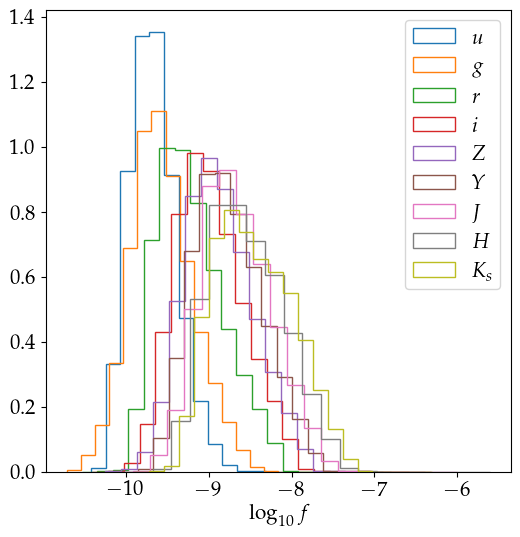

In [35]:
plt.figure(figsize=(6, 6))
for i in range(9):
    fluxvalues = flux_corr.values[:,i][mag_corr.values[:,i] != 99.0]
    print(f'Number of objects with good flux is {fluxvalues.shape[0]}')
    plt.hist(np.log10(fluxvalues), density=True, bins=20, histtype='step', label = f'{labels[i]}')
plt.xlabel(r'$\textrm{log}_{10}\,f$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.savefig('/home/harry/Desktop/scaled_flux.pdf', bbox_inches = 'tight')
plt.show()

# Filters

In [36]:
def get_filters(folder: str, filternames: list, lambdamin = 2.5E3, lambdamax = 3E4) -> Tuple[dict, dict, dict]:
    """
    Get the filters to be used to calculate the flux.

    Args:
        folder (str): folder where the filters are stored.
        filternames (list): name of all the filters
        lambdamin (float): the minimum wavelength imposed
        lambdamax (float): the maximum wavelength imposed

    Returns:
        Tuple[dict, dict, dict]: the filter, its wavelength range, the minimum and maximum wavelength.
    """
    record = dict()
    record_wavelength = dict()
    record_minmax = dict()

    for f in filternames:
        data = np.genfromtxt(os.path.join(folder, f'{f}.res'))
        wavelength, filt = data[:, 0], data[:, 1]
        if f in ['Z', 'Y', 'J', 'H', 'Ks']:
            wavelength *= 10 # because the units are in micron instead of angstrom
        
        condition = (wavelength > lambdamin) & (wavelength <= lambdamax)
        wavelength = wavelength[condition]
        filt = filt[condition]
        
        # the filter is divided by wavelength here
        filt /= wavelength
        norm = np.trapz(filt, wavelength)
        filt /= norm

        # find minimum and maximum wavelength
        ind = np.where(filt > 1E-4 * np.max(filt))[0]
        lambda_min, lambda_max = wavelength[ind[0]], wavelength[ind[-1]]

        record[f.split(".")[0]] = filt[ind]
        record_minmax[f.split(".")[0]] = [lambda_min, lambda_max]
        record_wavelength[f.split(".")[0]] = wavelength[ind]

    return record, record_wavelength, record_minmax

In [37]:
def get_seds(folder: str, waveref: float = 7E3, maxwave = 3E4) -> dict:
    """
    Get the SEDs from the folder and the SEDs are normalised at a particular wavelength.

    Args:
        folder (str): folder where the SEDs are stored.
        waveref (float, optional): the wavelength at which the SEDs are standardised. Defaults to 4e5.

    Returns:
        dict: dictionary with the standardised SEDs.
    """
    sednames = os.listdir(folder)
    seds = dict()
    for i, t in enumerate(sednames):
        seddata = np.genfromtxt(f"{folder}/{t}")
        seddata[:, 1] *= seddata[:, 0] ** 2.0 / 3e18
        ref = np.interp(waveref, seddata[:, 0], seddata[:, 1])
        seddata[:, 1] /= ref
        condition = seddata[:,0] <= maxwave
        seds[t.split(".")[0]] = seddata[condition]
    return seds

In [207]:
seds = get_seds('seds')
nseds = len(seds)
templatenames = list(seds.keys())

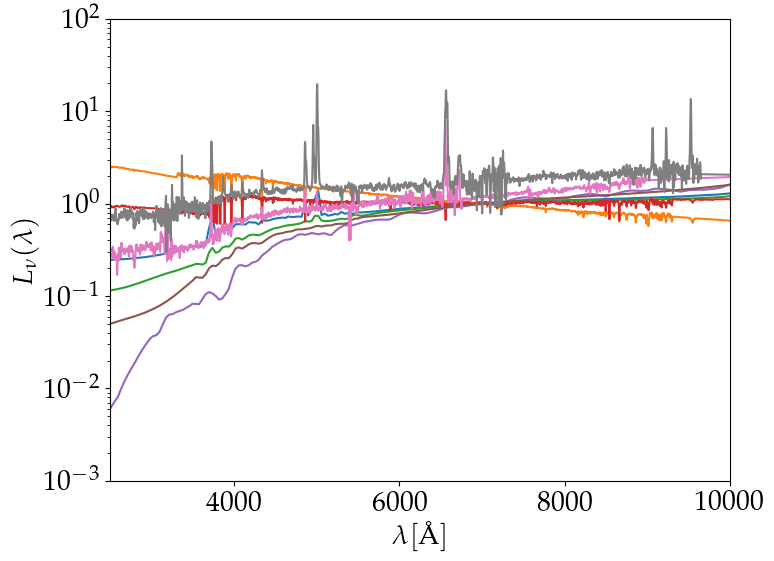

In [39]:
plt.figure(figsize=(8,6))
for fname in templatenames:
    plt.plot(seds[fname][:,0], seds[fname][:,1])
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$L_{\nu}(\lambda)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.xlim(2.5E3, 2.5E4)
plt.xlim(2.5E3, 10E3)
plt.ylim(1E-3, 1E2)
plt.yscale('log')
plt.show()

In [40]:
filters, filterwave, filterwaverange = get_filters('filters', CONFIG.band, lambdamin = 2.5E3, lambdamax = 2.5E4)

In [41]:
# for k in filters.keys():
#     print(f"{k}: {np.trapz(filters[k], filterwave[k]):.1f}")

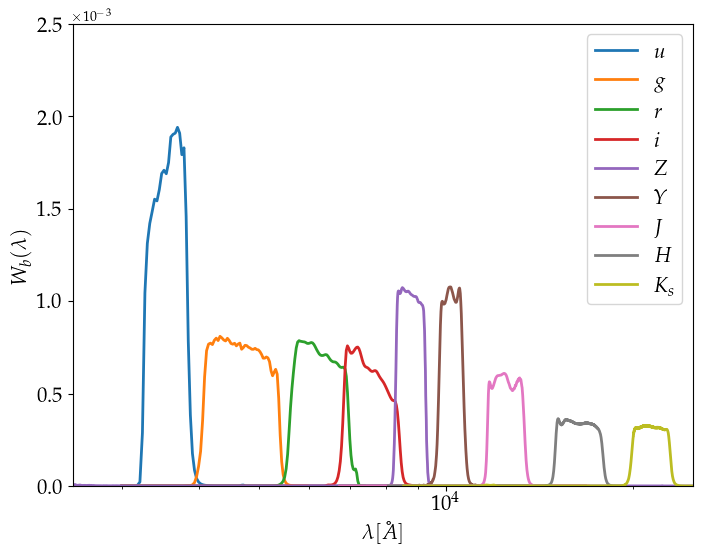

In [42]:
plt.figure(figsize = (8,6))
for i, key in enumerate(CONFIG.band):
    plt.plot(filterwave[key], filters[key], lw = 2, label = labels[i])
plt.xlim(2.5E3, 2.5E4)
plt.ylim(0, 0.0025)
plt.ylabel(r'$W_b(\lambda)$', fontsize=15)
plt.xlabel(r'$\lambda [\AA]$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig('/home/harry/Desktop/filters.pdf', bbox_inches = 'tight')
plt.show()

In [43]:
def approx_lum_dist(redshift: float) -> float:
    """
    Calculates the approximate luminosity distance given a redshift.

    Args:
        redshift (float): the redshift value.

    Returns:
        float: the approximate luminosity distance.
    """
    return np.exp(30.5 * redshift**0.04 - 21.7)

In [44]:
def get_flux(
    filters: dict, wavelengths: dict, lambdaminmax: dict, seds: dict, redshift: float
) -> pd.DataFrame:
    """
    Calculate the theoretical flux. The output is a dataframe of size Nt x Nf,
    where Nt is the number of templates and Nf is the number of filters.

    Args:
        filters (dict): a dictionary of filters.
        wavelengths (dict): a dictionary of the wavelength range.
        lambdaminmax (dict): the minimum and maximum of wavelength.
        seds (dict): a dictionary with all the SEDs/templates.
        redshift (float): the redshift value.

    Returns:
        pd.DataFrame: a dataframe of fluxes for Nt templates and Nf filters.
    """
    scaled_redshift = 1.0 + redshift
    nfilters = len(filters)
    nseds = len(seds)

    # calculate pre-factor
    lum_dist = approx_lum_dist(redshift)
    prefactor = scaled_redshift**2 / (4.0 * np.pi * lum_dist**2)

    # empty array to store the fluxes
    record_fluxes = dict()

    for i, s in enumerate(seds):
        fluxes = np.zeros(nfilters)
        for j, f in enumerate(filters):
            wave_grid = np.linspace(
                lambdaminmax[f][0] / scaled_redshift,
                lambdaminmax[f][1] / scaled_redshift,
                5000,
            )
            
            # build the interpolator
            filter_interp = interp1d(wavelengths[f] / scaled_redshift, filters[f])
            sed_interp = interp1d(seds[s][:, 0], seds[s][:, 1])
            
            # interpolate the quantities 
            filter_new = filter_interp(wave_grid)
            sed_new = sed_interp(wave_grid)
            fluxes[j] = prefactor * np.trapz(sed_new * filter_new, wave_grid)
        record_fluxes[s] = fluxes
    record_fluxes = pd.DataFrame(record_fluxes).T
    record_fluxes.columns = filters.keys()
    return record_fluxes

In [45]:
def spline_interpolate(inputs: np.ndarray, outputs: np.ndarray, new_inputs: np.ndarray) -> np.ndarray:
    """Performs a spline interpolation along the wavenumber axis

    Args:
        inputs (np.ndarray): the input wavenumber
        outputs (np.ndarray): the power spectrum, gradient or hessian
        new_inputs (np.ndarray): the new values of wavenumbers

    Returns:
        np.ndarray: the interpolated function
    """
    spline = itp.splrep(inputs, outputs)
    ynew = itp.splev(new_inputs, spline)
    return ynew

In [46]:
def calculate_loglike(data: np.ndarray, theory: np.ndarray, sigma: np.ndarray, magnitudes: np.ndarray):
    
    loglike = 0.0
    nband = len(data)
    for i in range(nband):
        if magnitudes[i] == 99.0:
            maxtheory = 15*sigma[i]
            theory_grid = np.linspace(0, maxtheory, 1000)
            errfunc = error_function(theory_grid, sigma[i], nu = 5)        
            if theory[i] > maxtheory:
                logfunc = 1E-32 * np.ones(1)
            else:
                value = spline_interpolate(theory_grid, errfunc, [theory[i]])
                logfunc = np.log(value)
        else:
            normal = ss.norm(theory[i], sigma[i])
            logfunc = normal.logpdf(data[i])
        loglike += logfunc
    return loglike.reshape(-1)

In [47]:
%%time
theory_flux = get_flux(filters, filterwave, filterwaverange, seds, 1.0)

CPU times: user 16.6 ms, sys: 162 µs, total: 16.8 ms
Wall time: 16.6 ms


In [48]:
theory_flux

,u,g,r,i,Z,Y,J,H,Ks
Im_B2004a,7.721433e-10,8.775674e-10,1.043973e-09,1.708902e-09,2.457158e-09,3.115173e-09,3.297758e-09,3.982123e-09,4.783554e-09
ssp_5Myr_z008,1.135398e-08,9.722113e-09,7.581234e-09,6.990500e-09,6.692092e-09,5.234040e-09,4.120220e-09,2.974557e-09,2.145368e-09
Scd_B2004a,3.235119e-10,4.005402e-10,6.159220e-10,1.094788e-09,1.877681e-09,2.431079e-09,3.215097e-09,3.909311e-09,4.708617e-09
ssp_25Myr_z008,3.754514e-09,3.517768e-09,3.123739e-09,3.455126e-09,4.236048e-09,3.753855e-09,3.662192e-09,3.702560e-09,4.004604e-09
El_B2004a,6.781881e-12,1.992536e-11,1.776167e-10,4.368992e-10,1.139739e-09,1.777139e-09,2.908443e-09,4.420287e-09,5.799219e-09
Sbc_B2004a,1.064528e-10,1.647940e-10,3.214405e-10,8.046687e-10,1.564617e-09,2.088946e-09,3.054134e-09,4.319165e-09,6.390550e-09
SB3_B2004a,8.715329e-10,9.721442e-10,1.234560e-09,1.737233e-09,2.848558e-09,3.295836e-09,4.535869e-09,5.390832e-09,7.077033e-09
SB2_B2004a,2.511822e-09,2.531916e-09,2.953187e-09,4.179647e-09,5.129366e-09,8.031412e-09,7.425632e-09,7.369716e-09,7.669400e-09


In [47]:
# %%capture
# import ray
# !ray start --head
# ray.init(address='auto')

# PDF of redshift

In [49]:
def calculate_redshift_pdf(zrange, fluxdata, fluxerr, magvalues, filters, filterwave, filterwaverange, seds):
    """
    We iterate over template and redshift and calculate p(z|template)
    
    fluxdata is a datavector of size 9. 
    fluxerr is a datavector of size 9. 
    magvalues is a datavector of size 9. 
    filters is a dictionary containing the filters for the 9 bands. 
    filterwave is a dictionary containing the wavelengths for the 9 bands. 
    filterwaverange is a dictionary containing the minimum and maximum redshift for each band. 
    seds is a dictionary containing the templates and each template has a 2D array, 
    the first column being wavelength and the second column the SED. 
    """
    record = {}
    for i, t in enumerate((seds.keys())):
        record[t] = []
        for z in zrange:
            # this is a dataframe of size Nt (number of templates) x Nb (number of bands)
            theory_flux = get_flux(filters, filterwave, filterwaverange, seds, z)
            loglike = calculate_loglike(fluxdata, theory_flux.loc[t].values, fluxerr, magvalues)
            record[t].append(loglike)
        record[t] = np.asarray(record[t]).reshape(-1)
        record[t] -= np.max(record[t])
        record[t] = np.exp(record[t])
        record[t] /= np.trapz(record[t], zrange)
    pdf_z = pd.DataFrame(record).T
    return pdf_z

In [50]:
def interpolate_redshift_pdf(zrange, pdfs, newzrange):
    """
    Interpolate the pdf of redshift. 
    zrange -> coarse redshift domain 
    pdfs -> coarse p(z)
    newzrange -> fine redshift bins
    """
    record = {}
    for i, t in enumerate(pdfs.index):
        record[t] = spline_interpolate(zrange, pdfs.loc[t], newzrange)
    return pd.DataFrame(record).T

In [695]:
index_object = 5
deltaz_coarse = 0.05
deltaz_fine = 0.0025
zgrid = np.arange(0, 8, deltaz_coarse) + deltaz_coarse
zfine = np.arange(0, 8, deltaz_fine) + deltaz_fine

ncoarse_z = len(zgrid)
nfine_z = len(zfine)
print(f'Number of coarse redshift bins is: {ncoarse_z}')
print(f'Number of fine redshift bins is: {nfine_z}')

Number of coarse redshift bins is: 160
Number of fine redshift bins is: 3200


In [696]:
fluxdata = flux_corr.iloc[index_object].values
fluxerr = fluxerr_corr.iloc[index_object].values
fluxerr_c = fluxerr_corr_scaled.iloc[index_object].values
magvalues = mag_corr.iloc[index_object].values.astype(np.float64)

In [697]:
%%time
pdfz_nocorr= calculate_redshift_pdf(zgrid, fluxdata, fluxerr, magvalues, filters, filterwave, filterwaverange, seds)

CPU times: user 24.5 s, sys: 0 ns, total: 24.5 s
Wall time: 24.5 s


In [698]:
%%time
pdfz_corr = calculate_redshift_pdf(zgrid, fluxdata, fluxerr_c, magvalues, filters, filterwave, filterwaverange, seds)

CPU times: user 24.4 s, sys: 0 ns, total: 24.4 s
Wall time: 24.4 s


In [699]:
pdfz_nocorr_fine = interpolate_redshift_pdf(zgrid, pdfz_nocorr, zfine)
pdfz_corr_fine = interpolate_redshift_pdf(zgrid, pdfz_corr, zfine)

In [700]:
ind = np.unravel_index(np.argmax(pdfz_corr_fine.values, axis=None), pdfz_corr_fine.values.shape)

In [701]:
print(f'Redshift MLE is: {zfine[ind[1]]:.3f}')

Redshift MLE is: 1.097


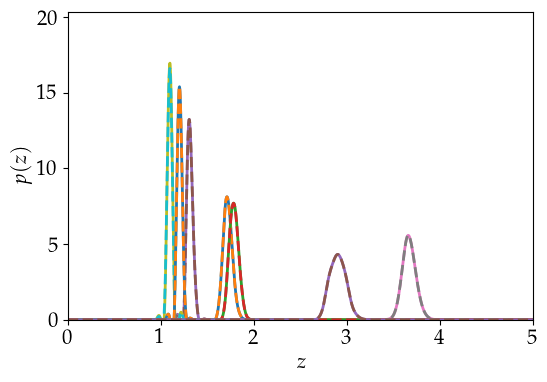

In [702]:
plt.figure(figsize=(6,4))
for i in range(pdfz_nocorr.shape[0]):
    plt.plot(zfine, pdfz_nocorr_fine.iloc[i].values, lw = 2)
    plt.plot(zfine, pdfz_corr_fine.iloc[i].values, lw = 2, linestyle = '--')
plt.ylabel(r'$p(z)$', fontsize=15)
plt.xlabel(r'$z$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
# plt.xlim(0, max(zfine))
plt.xlim(0, 5)
plt.ylim(0, 1.2*pdfz_nocorr.max(1).max())
plt.show()

# Numba

https://stackoverflow.com/questions/76509000/large-matrix-multiplication-with-low-memory-usage-in-numpy

In [703]:
import numba
from numba import jit
from numba.typed import List
import math

In [704]:
numba_filters = List([filters[key] for key in filters.keys()])
numba_filterwave = List([filterwave[key] for key in filters.keys()])
numba_filterwaverange = List(np.array(filterwaverange[key]) for key in filters.keys())
numba_seds = List(seds[key] for key in seds.keys())

In [705]:
# filters, filterwave, filterwaverange, seds

In [706]:
@jit(nopython=True)
def numba_approx_lum_dist(redshift: float) -> float:
    """
    Calculates the approximate luminosity distance given a redshift.

    Args:
        redshift (float): the redshift value.

    Returns:
        float: the approximate luminosity distance.
    """
    return np.exp(30.5 * redshift**0.04 - 21.7)

In [707]:
@jit(nopython=True)
def numba_get_flux(filters: List, wavelengths: List, lambdaminmax: List, seds: List, redshift: float):
    """
    Calculate the theoretical flux. The output is a dataframe of size Nt x Nf,
    where Nt is the number of templates and Nf is the number of filters.

    Args:
        filters (dict): a dictionary of filters.
        wavelengths (dict): a dictionary of the wavelength range.
        lambdaminmax (dict): the minimum and maximum of wavelength.
        seds (dict): a dictionary with all the SEDs/templates.
        redshift (float): the redshift value.

    Returns:
        pd.DataFrame: a dataframe of fluxes for Nt templates and Nf filters.
    """
    scaled_redshift = 1.0 + redshift
    nfilters = len(filters)
    nseds = len(seds)

    # calculate pre-factor
    lum_dist = numba_approx_lum_dist(redshift)
    prefactor = scaled_redshift**2 / (4.0 * np.pi * lum_dist**2)

    # empty array to store the fluxes
    record_fluxes = np.zeros((len(seds), len(filters)))

    for i in range(nseds):
        fluxes = np.zeros(nfilters)
        for j in range(nfilters):
            wave_grid = np.linspace(
                lambdaminmax[j][0] / scaled_redshift,
                lambdaminmax[j][1] / scaled_redshift,
                5000,
            )
            
            # build the interpolator
            filter_new = np.interp(wave_grid, wavelengths[j] / scaled_redshift, filters[j])
            sed_new = np.interp(wave_grid, seds[i][:, 0], seds[i][:, 1])
            fluxes[j] = prefactor * np.trapz(sed_new * filter_new, wave_grid)
        record_fluxes[i] = fluxes
    return record_fluxes

In [708]:
@jit(nopython=True)
def numba_error_function(theory, sigma, nu):
    erfc_inputs = (theory - nu*sigma)/(np.sqrt(2) * sigma)
    erfcs = 0.5 * np.array([math.erfc(x) for x in erfc_inputs])
    normalisation = np.trapz(erfcs, theory)
    return erfcs/normalisation

In [709]:
@jit(nopython=True)
def numba_1d_gaussian(mean, sigma, value):
    chi2 = (mean - value)**2 / sigma**2
    factor = 2.0 * math.pi * sigma**2
    logpdf = -0.5 * chi2 - 0.5 * np.log(factor)
    return logpdf

In [710]:
@jit(nopython=True)
def numba_calculate_loglike(data: np.ndarray, theory: np.ndarray, sigma: np.ndarray, magnitudes: np.ndarray):
    nband = len(data)
    loglike = np.zeros(nband)
    for i in range(nband):       
        if magnitudes[i] == 99.0:
            maxtheory = 15*sigma[i]
            theory_grid = np.linspace(0, maxtheory, 1000)
            errfunc = numba_error_function(theory_grid, sigma[i], nu = 5)        
            if theory[i] > maxtheory:
                logl = 1E-32 
            else:
                logl = np.log(np.interp(theory[i], theory_grid, errfunc)).item()
        else:
            logl = numba_1d_gaussian(theory[i], sigma[i], data[i])
        loglike[i] = logl
    return sum(loglike)

In [711]:
@jit(nopython=True, cache=True)
def numba_calculate_redshift_pdf(zrange, fluxdata, fluxerr, magvalues, filters, filterwave, filterwaverange, seds):
    """
    We iterate over template and redshift and calculate p(z|template)
    
    fluxdata is a datavector of size nobject x 9. 
    fluxerr is a datavector of size nobject x 9. 
    magvalues is a datavector of size nobject x 9. 
    filters is a dictionary containing the filters for the 9 bands. 
    filterwave is a dictionary containing the wavelengths for the 9 bands. 
    filterwaverange is a dictionary containing the minimum and maximum redshift for each band. 
    seds is a dictionary containing the templates and each template has a 2D array, 
    the first column being wavelength and the second column the SED. 
    """
    nseds = len(seds)
    nredshift = len(zrange)
    nobject = fluxdata.shape[0]
    
    # the theory is calculated once 
    record_theory = List()
    for j in range(nredshift):
        # this is an array of size Nt (number of templates) x Nb (number of bands)
        theory_flux = numba_get_flux(filters, filterwave, filterwaverange, seds, zrange[j])
        record_theory.append(theory_flux)
    
    # now calculate the log-likelihood
    record = np.zeros((nobject, nseds, nredshift), dtype = np.float32)
    for k in range(nobject):
        for i in range(nseds):
            for j in range(nredshift):
                record[k, i, j] = numba_calculate_loglike(fluxdata[k], record_theory[j][i], fluxerr[k], magvalues[k])
            record[k, i] -= np.max(record[k, i])
            record[k, i] = np.exp(record[k, i])
            record[k, i] /= np.trapz(record[k, i], zrange)
    return record

In [712]:
def numba_interpolate_redshift_pdf(zrange, pdfs, newzrange):
    """
    Interpolate the pdf of redshift. 
    zrange -> coarse redshift domain 
    pdfs -> coarse p(z)
    newzrange -> fine redshift bins
    """
    record = []
    for i in range(pdfs.shape[0]):
        pdf_intp = spline_interpolate(zrange, pdfs[i], newzrange)
        record.append(pdf_intp)
    record = np.asarray(record)
    return record

# First run. 

Just run/compile for 2 objects, followed by a full run.

In [713]:
def generate_random(nobjects, maxint):
    index_random = random.sample(range(maxint), nobjects)
    return index_random

In [714]:
index_random = generate_random(2, NOBJ)
fluxdata = flux_corr.values[index_random]
fluxerr = fluxerr_corr.values[index_random]
fluxerr_c = fluxerr_corr_scaled.values[index_random]
magvalues = mag_corr.values.astype(np.float64)[index_random]
magerr_c = magerr_corr.values.astype(np.float64)[index_random]

In [715]:
%%time
loglike = numba_calculate_redshift_pdf(zgrid, fluxdata, fluxerr_c, magvalues, numba_filters, numba_filterwave, numba_filterwaverange, numba_seds)

CPU times: user 993 ms, sys: 0 ns, total: 993 ms
Wall time: 991 ms


In [716]:
%%time
loglike = numba_calculate_redshift_pdf(zgrid, fluxdata, fluxerr_c, magvalues, numba_filters, numba_filterwave, numba_filterwaverange, numba_seds)

CPU times: user 973 ms, sys: 0 ns, total: 973 ms
Wall time: 970 ms


Then, run for $N_{object}>2$.

In [717]:
index_random = generate_random(5000, NOBJ)
fluxdata = flux_corr.values[index_random]
fluxerr = fluxerr_corr.values[index_random]
fluxerr_c = fluxerr_corr_scaled.values[index_random]
magvalues = mag_corr.values.astype(np.float64)[index_random]
magerr_c = magerr_corr.values.astype(np.float64)[index_random]

In [718]:
%%time
loglike = numba_calculate_redshift_pdf(zgrid, fluxdata, fluxerr_c, magvalues, numba_filters, numba_filterwave, numba_filterwaverange, numba_seds)

CPU times: user 55.1 s, sys: 77.5 ms, total: 55.2 s
Wall time: 55 s


In [719]:
def store_arrays(array: np.ndarray, folder_name: str, file_name: str) -> None:
    """Stores a numpy array in a folder.

    Args:
        array (np.ndarray): The array to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # use compressed format to store data
    np.savez_compressed(folder_name + '/' + file_name + '.npz', array)
    
def get_numpy_size(array: np.ndarray):
    """
    Get the size of the numpy array in MB.
    """
    size = array.nbytes / 1024**2
    return f'Size in MB is {round(size, 2)}'


def create_sparse_tensor(tensor: np.ndarray, fname: str = None):
    
    # set the very small values to zero 
    tensor[tensor < 1E-5] = 0.0
    
    # convert to PyTorch tensor
    pt_tensor = torch.from_numpy(tensor)
    
    # generate sparse tensor in PyTorch 
    pt_sparse = pt_tensor.to_sparse()
    
    # get the values, indices and size
    values = pt_sparse.values().type(torch.float32)
    indices = pt_sparse.indices().type(torch.int16)
    size = pt_sparse.size()
        
    if fname:
        os.makedirs('likelihood', exist_ok=True)
        val_path = os.path.join('likelihood', f'values_{fname}.pt')
        ind_path = os.path.join('likelihood', f'indices_{fname}.pt')
        siz_path = os.path.join('likelihood', f'size_{fname}.pt')
        torch.save(values, val_path)
        torch.save(indices, ind_path)
        torch.save(size, siz_path)
        
def load_sparse_tensor(fname: str):

    val_path = os.path.join('likelihood', f'values_{fname}.pt')
    ind_path = os.path.join('likelihood', f'indices_{fname}.pt')
    siz_path = os.path.join('likelihood', f'size_{fname}.pt')
        
    values = torch.load(val_path)
    indices = torch.load(ind_path)
    size = torch.load(siz_path)
    
    tensor = torch.sparse_coo_tensor(indices, values, size).to_dense().numpy()
    return tensor

Create and save the sparse tensor.

In [720]:
create_sparse_tensor(loglike, fname = 'test_01')

Load the sparse tensor and check with original one

In [721]:
loglike_test = load_sparse_tensor('test_01')

In [722]:
get_numpy_size(loglike)

'Size in MB is 24.41'

In [723]:
get_numpy_size(loglike_test)

'Size in MB is 24.41'

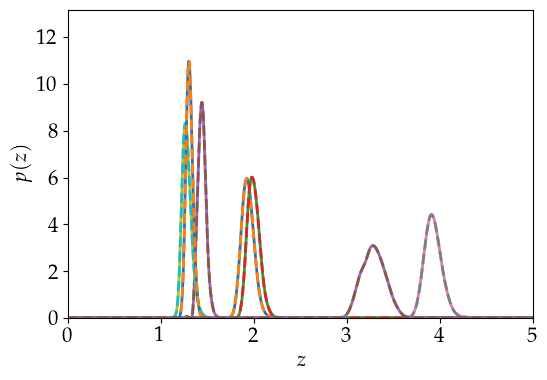

In [724]:
loglike_fine_test = numba_interpolate_redshift_pdf(zgrid, loglike_test[index_object], zfine)
loglike_fine = numba_interpolate_redshift_pdf(zgrid, loglike[index_object], zfine)

plt.figure(figsize=(6,4))
for i in range(nseds):
    plt.plot(zfine, loglike_fine[i], lw = 2)
    plt.plot(zfine, loglike_fine_test[i], lw = 2, linestyle = '--')
plt.ylabel(r'$p(z)$', fontsize=15)
plt.xlabel(r'$z$', fontsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
# plt.xlim(0, max(zfine))
plt.xlim(0, 5)
plt.ylim(0, 1.2*np.amax(loglike_fine))
plt.show()

# Reference Magnitude

In [725]:
deltam_coarse = 0.1
deltam_fine = 0.005

In [726]:
mgrid = np.arange(16, 26, deltam_coarse) + deltam_coarse
mfine = np.arange(16, 26, deltam_fine) + deltam_fine

ncoarse_m = len(mgrid)
nfine_m = len(mfine)

print(f'Number of coarse magnitude bins is: {ncoarse_m}')
print(f'Number of fine magnitude bins is: {nfine_m}')

Number of coarse magnitude bins is: 100
Number of fine magnitude bins is: 2000


In [958]:
ref_index = 2
index_object = 5
mag_test = magvalues[index_object]
mag_err_test = magerr_c[index_object]
std_mag = mag_err_test[ref_index]

In [959]:
pdf_m = ss.norm(mag_test[ref_index], mag_err_test[ref_index]).pdf(mgrid)
pdf_tz = loglike[index_object]
pdf_tzm = np.outer(pdf_zt, pdf_m).reshape(nseds, ncoarse_z, ncoarse_m)

In [960]:
ind = np.unravel_index(np.argmax(pdf_tzm, axis=None), pdf_tzm.shape)
temp_max, red_max, mag_max = ind[0], zgrid[ind[1]], mgrid[ind[2]]

In [961]:
interp = RegularGridInterpolator((zgrid, mgrid), pdf_tzm[temp_max])

In [962]:
condition = loglike[index_object][temp_max] > 0
zgrid_sub = zgrid[condition]
pdf_zsub = loglike[index_object][temp_max][condition]

In [963]:
meanz_sub = np.trapz(zgrid_sub * pdf_zsub, zgrid_sub)
varz_sub = np.trapz((zgrid_sub - meanz_sub)**2 * pdf_zsub, zgrid_sub)
if varz_sub == 0.0 and meanz_sub == 0.0:
    varz_sub = 1E-4
    meanz_sub = zgrid_sub
stdz_sub = np.sqrt(varz_sub)

In [964]:
ztest = np.linspace(meanz_sub - 5 * stdz_sub, meanz_sub + 5 * stdz_sub, 1000)
distribution = ss.norm(meanz_sub, stdz_sub)
pdf_ztest = distribution.pdf(ztest)

In [965]:
zmin = red_max - 5 * stdz_sub
zmax = red_max + 5 * stdz_sub
mmin = mag_max - 5 * std_mag
mmax = mag_max + 5 * std_mag

if zmin < min(zgrid):
    zmin = min(zgrid)
if zmax > max(zgrid):
    zmax = max(zgrid)
if mmin < min(mgrid):
    mmin = min(mgrid)
if mmax > max(mgrid):
    mmax = max(mgrid)
    
deltaz = zmax - zmin 
deltam = mmax - mmin 

uniform_z = ss.uniform(zmin, deltaz).ppf(np.random.uniform(0, 1, 50))
uniform_m = ss.uniform(mmin, deltam).ppf(np.random.uniform(0, 1, 50))

In [976]:
testpoints = np.vstack([uniform_z, uniform_m]).T

In [977]:
pdf_random = interp(testpoints)
samples_accept = testpoints[pdf_random > min(pdf_random)]
idx = np.random.randint(samples_accept.shape[0], size=1)

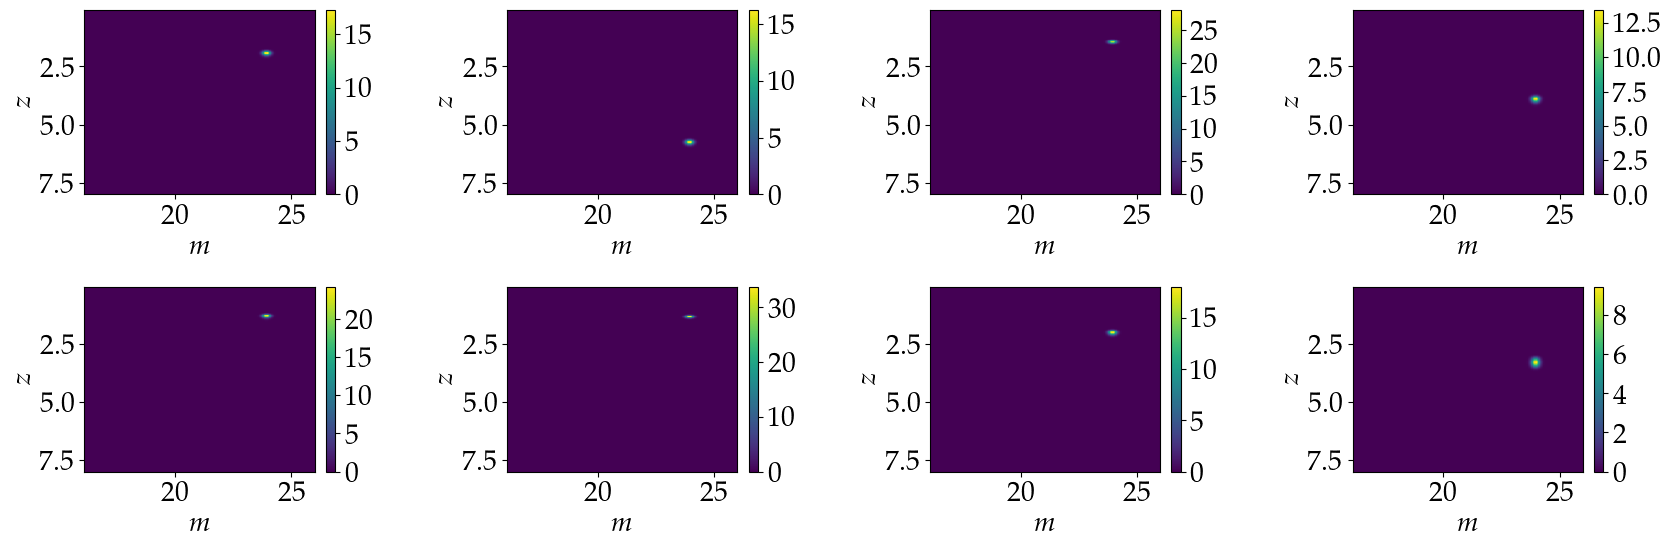

In [980]:
plt.figure(figsize = (20, 6))
for i in range(nseds):
    plt.subplot(2, 4, i+1)
    im = plt.imshow(pdf_tzm[i], extent=[min(mgrid), max(mgrid), max(zgrid),min(zgrid)])
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(fontSize)
    plt.ylabel(r'$z$', fontsize = fontSize)
    plt.xlabel(r'$m$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.show()

The above re-written in functions.

In [953]:
def gaussian_distribution_pdf(mean, sigma, values):
    factor = 1.0 / np.sqrt(2.0 * np.pi * sigma**2)
    chi2 = (values - mean)**2 / sigma**2
    return factor * np.exp(-0.5 * chi2)

def summary_objects(pdf_tz, zgrid, mgrid, magvalue, magvalue_error, ref_index):
    
    mag = magvalue[ref_index]
    mag_e = magvalue_error[ref_index]
    pdf_m = gaussian_distribution_pdf(mag, mag_e, mgrid)
    
    nseds = pdf_zt.shape[0]
    ngridz = pdf_zt.shape[1]
    ngridm = mgrid.shape[0]
    
    pdf_tzm = np.outer(pdf_tz, pdf_m).reshape(nseds, ngridz, ngridm)
    
    statistics = {}
    
    for i in range(nseds):
        ind = np.unravel_index(np.argmax(pdf_tzm[i], axis=None), pdf_tzm[i].shape)
        red_max, mag_max = zgrid[ind[0]], mgrid[ind[1]]
        
        # estimate the standard deviation of the redshift slice
        condition = pdf_tz[i] > 0
        zgrid_sub = zgrid[condition]
        pdf_zsub = pdf_tz[i][condition]

        meanz_sub = np.trapz(zgrid_sub * pdf_zsub, zgrid_sub)
        varz_sub = np.trapz((zgrid_sub - meanz_sub)**2 * pdf_zsub, zgrid_sub)
        if varz_sub == 0.0 and meanz_sub == 0.0:
            varz_sub = 1E-4
            meanz_sub = zgrid_sub
        stdz_sub = np.sqrt(varz_sub)
        
        interp = RegularGridInterpolator((zgrid, mgrid), pdf_tzm[i])
        
        statistics[i] = {'z_peak': round(red_max, 5), 
                         'm_peak': round(mag_max, 5), 
                         'z_std': round(stdz_sub, 5), 
                         'm_std': round(mag_e, 5),
                         'dist': interp}
    return statistics

def draw_samples(summaries, zgrid, mgrid, nsamples):
    
    nsummaries = len(summaries)
    
    record_samples = []
    for i in range(nsummaries):

        zmin = summaries[i]['z_peak'] - 5 * summaries[i]['z_std']
        zmax = summaries[i]['z_peak'] + 5 * summaries[i]['z_std']
        mmin = summaries[i]['m_peak'] - 5 * summaries[i]['m_std']
        mmax = summaries[i]['m_peak'] + 5 * summaries[i]['m_std']
        
        if zmin < min(zgrid):
            zmin = min(zgrid)
        if zmax > max(zgrid):
            zmax = max(zgrid)
        if mmin < min(mgrid):
            mmin = min(mgrid)
        if mmax > max(mgrid):
            mmax = max(mgrid)
            
        z_samples = np.random.uniform(zmin, zmax, nsamples)
        m_samples = np.random.uniform(mmin, mmax, nsamples)
        testsamples = np.vstack([z_samples, m_samples]).T
        
        pdf_random = summaries[i]['dist'](testsamples)
        samples_accept = testsamples[pdf_random > min(pdf_random)]   
        idx = np.random.randint(samples_accept.shape[0], size=1)
        samples = np.concatenate([i*np.ones(1), samples_accept[idx].reshape(-1)])
        record_samples.append(samples)
    return record_samples

In [985]:
%%time
summaries = summary_objects(pdf_zt, zgrid, mgrid, mag_test, mag_err_test, ref_index)

CPU times: user 2.2 ms, sys: 0 ns, total: 2.2 ms
Wall time: 1.93 ms


In [986]:
%%time
samples = draw_samples(summaries, zgrid, mgrid, 10)

CPU times: user 2.7 ms, sys: 0 ns, total: 2.7 ms
Wall time: 2.8 ms


In [987]:
samples

[array([ 0.        ,  1.87130706, 24.26543301]),
 array([ 1.        ,  6.02057515, 23.60930506]),
 array([ 2.        ,  1.41542287, 24.31680256]),
 array([ 3.        ,  3.87978735, 23.43845741]),
 array([ 4.        ,  1.42167742, 23.79884145]),
 array([ 5.        ,  1.27822078, 23.71734769]),
 array([ 6.        ,  2.31068542, 23.46399166]),
 array([ 7.        ,  3.48311948, 23.63669544])]

# BHM Step